# Number of feeds with data about physical accessibility

[GH issue](https://github.com/cal-itp/data-infra/issues/553)

MVP:

* Presence of `stops#wheelchair_boarding` field
* Presence of `trips#wheelchair_accessible` field
* Presence of non-empty pathways table when at least one child_stop within parent_stop exists in stops

More rigorous analysis:

Require minimum percent of:
* Rows in stops table with `wheelchair_boarding` field set to "not unknown" value
* Rows in trips table with `wheelchair_accessible` field set to "not unknown" value
* Child_stops within a parent_stop that can reach every other child_stop within parent_stop when simulating travel as an able-bodied person

**Data Sources:**
* Static GTFS
* `stops#wheelchair_boarding`
* `trips#wheelchair_accessible`
* Pathways data as it relates to child and parent stops

### Method 1:
The first way is to calculate the total number of feeds that meet all of the 3 conditions:

* 100% of stops have a value of 1 or 2 in the wheelchair_boarding field.
* 100% of trips have a value of 1 or 2 in the wheelchair_accessible field.
* If any of the stops have a parent stop, there needs to be at least 1 record in the pathways file. If no stops have a parent stop, then this criteria is satisfied.

### Method 2:
The second way is to give a weighted answer by adding up the per-feed score across all feeds where a feed's score is calculated as follows:
```
# set a pathways_required variable to true if any of the stops have a parent stop defined
num_parent_stops = count_num_parent_stops()
pathways_required = num_parent_stops > 0

# find weight to use for trips and stops based on whether pathways data is required
stops_and_trips_weight = 0.3333 if pathways_required else 0.5

# calculate overall accessible score
feed_score = (
    stops_and_trips_weight * calculate_percent_of_stops_with_explicitly_defined_wheelchair_code() + 
    stops_and_trips_weight * calculate_percent_of_trips_with_explicitly_defined_wheelchair_code() + 
    # TODO: a more rigorous analysis that checks if each child-stop of a parent is able to be accessed to 
    # every other child-stop of the parent stop would be needed to calculate a more realistic value here.
    # Until then, a full score on pathways-completeness is given if more than 0 pathways entries exist.
    (0 if not pathways_required else 0.3333 if count_num_pathways() > 0 else 0)
) / (3 if pathways_required else 2)
```

### Findings
1. One graph is complete info vs missing info (marked as no is ok).
1. Another graph is aggregating the feed_score over all the operators-feeds (measure of info completeness). 

In [1]:
import altair as alt
import altair_saver
import pandas as pd
import os
#os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)

import calitp
from calitp.tables import tbl
from siuba import *

from shared_utils import altair_utils

alt.themes.enable("fivethirtyeight")

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


ThemeRegistry.enable('fivethirtyeight')

In [2]:
from IPython.display import display, SVG

alt.renderers.enable('altair_saver', fmts=['svg'])

def show_svg(image_name):
    image_path = f"./{image_name}.svg"
    altair_saver.save(image_name, image_path)
    display(SVG(filename = image_path))
    os.remove(image_path)

In [3]:
'''
stops = (tbl.gtfs_schedule.stops()
      # unique on itp_id and url_number
      # but there are handful of agencies where same stop has multiple url's
      >> select(_.calitp_itp_id, _.calitp_url_number, 
                _.stop_id, _.wheelchair_boarding, )
      >> arrange(_.calitp_itp_id, _.stop_id, _.calitp_url_number)
      >> collect()
)

stops.to_parquet("./accessibility_stops.parquet")
'''
stops = pd.read_parquet("./accessibility_stops.parquet")

'''
# For now, keep all feeds until we can determine primary analysis feed

# Get rid of duplicates
stops = (stops.drop_duplicates(subset=["calitp_itp_id", "stop_id"])
      .reset_index(drop=True)
     )
'''

'\n# For now, keep all feeds until we can determine primary analysis feed\n\n# Get rid of duplicates\nstops = (stops.drop_duplicates(subset=["calitp_itp_id", "stop_id"])\n      .reset_index(drop=True)\n     )\n'

In [4]:
def categorize_values(df, col, values_dict = {}, new_colname = None):   
    if new_colname == None:
        new_colname = col
    df = (df.assign(
            col = df[col].fillna("unknown").map(values_dict)
        ).drop(columns = col)
          .rename(columns = {"col": new_colname})
    )
    
    return df


def summarize_metric_for_operator(df, group_cols = [], numerator="", denominator=""):
    df2 = (df.groupby(group_cols)
           .agg({
               numerator: "sum", 
               denominator: "count"
           }).reset_index()
          )
    
    df2 = df2.assign(
        pct = df2[numerator].divide(df2[denominator])
    ).rename(columns = {"pct": f"pct_{numerator}"})
           
    return df2


# May or may not need this function
# For now, still create a dummy variable whether it meets the metric to be plotted
def operator_above_threshold(df, col, threshold=0.50, new_colname = None):
    if new_colname is None:
        new_colname = col
        
    df = df.assign(
        meets_metric = df.apply(lambda x: 1 if x[col] >= threshold else 0, axis=1)
    ).rename(columns = {"meets_metric": new_colname})
    
    return df


def make_histogram(df, x_col):
    x_title = f"{x_col.replace('pct_has_', '').replace('_', ' ')} information"
              
    chart = (alt.Chart(df)
             .mark_bar()
             .encode( 
                 x=alt.X(f"{x_col}:Q", bin=True, title=f"% {x_title}"),
                 y=alt.Y("count()", title="# Operators"),
                 color=alt.value(altair_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS[0])
                 
             )
    )
    
    chart = (altair_utils.preset_chart_config(chart)
             .properties(title=f"Operators by % {x_title.title()}")
            )
    
    show_svg(chart)
    

In [5]:
'''
Using siuba

Not sure how to set up function with siuba operations...

(stops2
 >> group_by(_.calitp_itp_id, _.calitp_url_number)
 >> summarize(num_stops = _.stop_id.count(), 
              has_stop_accessibility = _.has_stop_accessibility.sum(),
             )
 >> mutate(pct_accessibility_info = _.has_stop_accessibility.divide(_.num_stops))
)
'''

'\nUsing siuba\n\nNot sure how to set up function with siuba operations...\n\n(stops2\n >> group_by(_.calitp_itp_id, _.calitp_url_number)\n >> summarize(num_stops = _.stop_id.count(), \n              has_stop_accessibility = _.has_stop_accessibility.sum(),\n             )\n >> mutate(pct_accessibility_info = _.has_stop_accessibility.divide(_.num_stops))\n)\n'

In [6]:
# https://gtfs.org/reference/static/#stopstxt
# 0 is unknown; 1 is accessible; 2 is not accessible
STOPS_VALUES_DICT = {
    "unknown": 0,
    "0": 0, 
    "1": 1,
    "2": 1,
}

stops2 = categorize_values(stops, "wheelchair_boarding", 
                           values_dict = STOPS_VALUES_DICT, 
                           new_colname = "has_stop_accessibility")

stops3 = summarize_metric_for_operator(stops2, 
                              group_cols = ["calitp_itp_id", "calitp_url_number"], 
                              denominator = "stop_id", 
                              numerator = "has_stop_accessibility")

stops4 = operator_above_threshold(stops3, "pct_has_stop_accessibility", 
                                  threshold=1.0, new_colname="stops_full_info")

stops4.head()

,calitp_itp_id,calitp_url_number,has_stop_accessibility,stop_id,pct_has_stop_accessibility,stops_full_info
0,0,0,0,866,0.000000,0
1,1,0,7,130,0.053846,0
2,1,1,9,254,0.035433,0
3,1,2,9,254,0.035433,0
4,1,3,0,350,0.000000,0


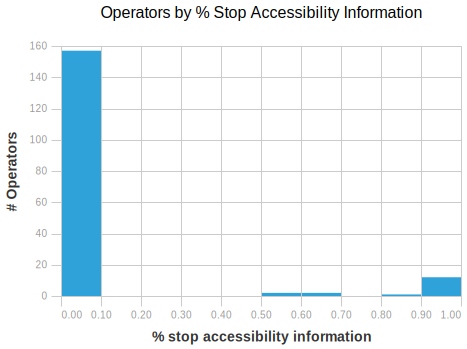

In [7]:
make_histogram(stops4, "pct_has_stop_accessibility")

In [8]:
'''
trips = (tbl.gtfs_schedule.trips()
      >> select(_.calitp_itp_id, _.calitp_url_number, 
                _.route_id, _.wheelchair_accessible, )
      >> group_by(_.calitp_itp_id, _.route_id, _.wheelchair_accessible)
      >> arrange(_.calitp_itp_id, _.route_id)
      >> collect()
)

trips.to_parquet("./accessibility_trips.parquet")
'''

trips = pd.read_parquet("./accessibility_trips.parquet")

In [9]:
# https://gtfs.org/reference/static/#tripstxt
# 0 is unknown; 1 is accessible; 2 is not accessible
TRIPS_VALUES_DICT = {
    "unknown": 0,
    "0": 0, 
    "1": 1,
    "2": 1,
}

trips2 = categorize_values(trips, "wheelchair_accessible", 
                           values_dict = TRIPS_VALUES_DICT, 
                           new_colname = "has_route_accessibility")

trips3 = summarize_metric_for_operator(trips2, 
                              group_cols = ["calitp_itp_id", "calitp_url_number"], 
                              denominator = "route_id", 
                              numerator = "has_route_accessibility")

trips4 = operator_above_threshold(trips3, "pct_has_route_accessibility", 
                                  threshold=1.0, new_colname="routes_full_info")

trips4.head()

,calitp_itp_id,calitp_url_number,has_route_accessibility,route_id,pct_has_route_accessibility,routes_full_info
0,0,0,0,2940,0.0,0
1,1,0,0,126,0.0,0
2,1,1,0,558,0.0,0
3,1,2,0,558,0.0,0
4,1,3,0,1167,0.0,0


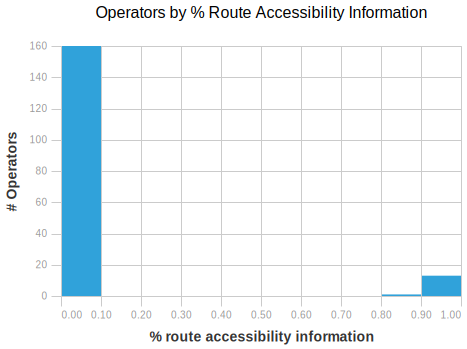

In [10]:
make_histogram(trips4, "pct_has_route_accessibility")

In [11]:
full_info = {
    "stops": len(stops4[stops4.stops_full_info==1]),
    "routes": len(trips4[trips4.routes_full_info==1]),
}

combined = (pd.DataFrame.from_dict(full_info, orient="index", columns=["value"])
        .reset_index()
        .rename(columns = {"index": "category"})
       )

combined

,category,value
0,stops,5
1,routes,13


In [ ]:
# This doesn't show unique operators
# If an operator has full information for both, it would show up twice
(alt.Chart(combined)
 .mark_bar()
 .encode(
     x="category",
     y="value"
 )

)

In [ ]:
def my_function(df, numerator, denominator):
    df = df.assign(
        pct = df[numerator] / df[denominator]
    )
    
    return df

def my_siuba_function(df, numerator, denominator):
    df = (df
          >> mutate(pct = numerator / denominator)
    )
    return df


def siuba_function(df, group_cols = [], numerator="", denominator=""):
    df2 = (df
           # unpack the list because siuba doesn't take list
           >> group_by(*group_cols)
           >> summarize(denominator = _[denominator].count(), 
                        numerator = _[numerator].sum()
                       )
           >> mutate(pct = _.numerator / _.denominator)
           # Not sure how to get the renaming done
           # Similar to .assign(), and renaming needs to be able to take f-string
    )
    return df2


siuba_function(stops2, group_cols = ["calitp_itp_id", "calitp_url_number"],
               numerator = "has_stop_accessibility",
               denominator = "stop_id").head()


In [ ]:
'''
pathways = (tbl.views.gtfs_schedule_dim_pathways()
 >> select(_.calitp_itp_id, 
           _.from_stop_id, _.to_stop_id,
           _.pathway_mode, _.pathway_id, _.pathway_key)
 >> inner_join(_, 
              (tbl.views.gtfs_schedule_fact_daily_pathways()
               >> select(_.pathway_key, _.date)
              ), 
              "pathway_key")
            >> collect()
)

pathways.to_parquet("./pathways.parquet")
'''
pathways = pd.read_parquet("./pathways.parquet")

In [ ]:
# Only 1 operator (Bay Area aggregate feed) has pathways
# Select the most recent date
pathways2 = (pathways
 >> group_by(_.calitp_itp_id)
 >> filter(_.date == _.date.max())
)

pathways2.calitp_itp_id.nunique()

In [ ]:
pathways2.head(2)

In [ ]:
def calculate_feed_score(stop_df, trip_df):
    df = pd.merge(stop_df, trip_df, 
                  on = ["calitp_itp_id", "calitp_url_number"],
                  how = "inner", 
                  validate = "1:1")
    
    STOP_WEIGHT = 0.5
    TRIP_WEIGHT = 0.5
    
    df = df.assign(
        feed_score = ((STOP_WEIGHT * df.pct_has_stop_accessibility) + 
                      (TRIP_WEIGHT * df.pct_has_route_accessibility)
                     )
    )
    
    return df
'''
# calculate overall accessible score
feed_score = (
    stops_and_trips_weight * calculate_percent_of_stops_with_explicitly_defined_wheelchair_code() + 
    stops_and_trips_weight * calculate_percent_of_trips_with_explicitly_defined_wheelchair_code() + 
    # TODO: a more rigorous analysis that checks if each child-stop of a parent is able to be accessed to 
    # every other child-stop of the parent stop would be needed to calculate a more realistic value here.
    # Until then, a full score on pathways-completeness is given if more than 0 pathways entries exist.
    (0 if not pathways_required else 0.3333 if count_num_pathways() > 0 else 0)
) / (3 if pathways_required else 2)
'''

In [ ]:
df = calculate_feed_score(stops4, trips4)
df.head()

In [ ]:
# Distribution of feed score
# Most are 0's, but can see that a 100% threshold only grabs very few operators
(alt.Chart(df)
 .mark_bar()
 .encode(
     x=alt.X("feed_score:Q", bin=True),
     y="count()"
 )
)

In [ ]:
# Add histogram for stops/trips for pct_accessible
# With validation errors, some errors show up a lot (not a big deal), but 
# some show up very infrequently but are actually very critical
# getting unique validation notices for each feed
# % of feeds with each type of notice

In [ ]:
# daily fact files, come up with metrics on per day basis
# but for quarterly dashboard? maybe not daily? discuss with E/Evan